In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings
warnings.filterwarnings('ignore')

# Set style settings
sns.set_theme()
sns.set_palette("husl")

# Notebook-wide settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

def load_feature_sets():
    """
    Load the preprocessed feature sets for both 24h and 7d predictions
    """
    # Load datasets with index_col=0 to use the first column as index
    df_24h = pd.read_csv('../data/processed/features_24h.csv', index_col=0)
    df_7d = pd.read_csv('../data/processed/features_7d.csv', index_col=0)
    
    # Convert index to datetime
    df_24h.index = pd.to_datetime(df_24h.index)
    df_7d.index = pd.to_datetime(df_7d.index)
    
    return df_24h, df_7d

# Load the datasets
df_24h, df_7d = load_feature_sets()

# Display basic information
print("24h Dataset Shape:", df_24h.shape)
print("7d Dataset Shape:", df_7d.shape)
print("\nFeature columns (24h):", df_24h.columns.tolist())

24h Dataset Shape: (35975, 108)
7d Dataset Shape: (35831, 114)

Feature columns (24h): ['avg_wind_speed', 'precipitation', 'avg_temperature', 'max_temperature', 'min_temperature', 'temperature', 'avg_wind_speed_chicago', 'precipitation_chicago', 'avg_temperature_chicago', 'temperature_chicago', 'avg_wind_speed_washington', 'precipitation_washington', 'avg_temperature_washington', 'temperature_washington', 'avg_wind_speed_pittsburgh', 'precipitation_pittsburgh', 'avg_temperature_pittsburgh', 'temperature_pittsburgh', 'avg_wind_speed_columbus', 'precipitation_columbus', 'year', 'hour', 'day', 'month', 'day_of_week', 'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'is_morning', 'is_afternoon', 'is_evening', 'is_night', 'is_weekend', 'PJME_lag_1h', 'PJMW_lag_1h', 'PJME_lag_2h', 'PJME_lag_3h', 'PJME_lag_6h', 'PJMW_lag_6h', 'PJME_lag_12h', 'PJMW_lag_12h', 'PJME_lag_24h', 'PJMW_lag_24h', 'PJME_lag_48h', 'PJMW_lag_48h', 'PJME_lag_72h', 'PJMW_lag_72h', 'P

In [2]:
def prepare_data_for_modeling(df, target_col='PJME', test_size=0.2, forecast_horizon=24):
    """
    Prepare data for modeling by splitting into features/target and train/test sets,
    ensuring we don't use future information in our predictions
    """
    # Remove lag features that we wouldn't have in a real forecasting scenario
    future_lags = [col for col in df.columns if 'lag' in col and int(col.split('_')[-1].replace('h','')) < forecast_horizon]
    rolling_stats = [col for col in df.columns if 'rolling' in col]
    consumption_changes = ['consumption_change_rate']
    
    features_to_drop = future_lags + rolling_stats + consumption_changes
    print(f"Removing {len(features_to_drop)} features that wouldn't be available for {forecast_horizon}h forecasting:")
    print(features_to_drop)
    
    # Create feature set without leaking features
    X = df.drop(columns=[target_col] + features_to_drop)
    y = df[target_col]
    
    # Calculate split point to maintain time series order
    split_idx = int(len(df) * (1 - test_size))
    
    # Split the data
    X_train = X[:split_idx]
    X_test = X[split_idx:]
    y_train = y[:split_idx]
    y_test = y[split_idx:]
    
    print(f"\nTraining set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")
    print(f"Training period: {X_train.index[0]} to {X_train.index[-1]}")
    print(f"Test period: {X_test.index[0]} to {X_test.index[-1]}")
    
    return X_train, X_test, y_train, y_test

# Prepare data for 24h predictions with proper feature selection
print("Preparing 24-hour prediction data:")
X_train_24h, X_test_24h, y_train_24h, y_test_24h = prepare_data_for_modeling(
    df_24h, 
    forecast_horizon=24
)

print("\nPreparing 7d prediction data:")
X_train_7d, X_test_7d, y_train_7d, y_test_7d = prepare_data_for_modeling(df_7d)

# Create a function to evaluate model performance
def evaluate_model(y_true, y_pred, model_name):
    """
    Calculate and print various evaluation metrics
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f"\n{model_name} Performance Metrics:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")
    
    return {'mae': mae, 'rmse': rmse, 'r2': r2, 'mape': mape}

# Function to plot predictions vs actual values
def plot_predictions(y_true, y_pred, title, window=168):  # window=168 shows one week
    """
    Plot the actual vs predicted values
    """
    plt.figure(figsize=(15, 6))
    plt.plot(y_true.index[-window:], y_true[-window:], label='Actual', alpha=0.7)
    plt.plot(y_true.index[-window:], y_pred[-window:], label='Predicted', alpha=0.7)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Energy Consumption')
    plt.legend()
    plt.grid(True)
    plt.show()

Preparing 24-hour prediction data:
Removing 18 features that wouldn't be available for 24h forecasting:
['PJME_lag_1h', 'PJMW_lag_1h', 'PJME_lag_2h', 'PJME_lag_3h', 'PJME_lag_6h', 'PJMW_lag_6h', 'PJME_lag_12h', 'PJMW_lag_12h', 'PJME_rolling_std_6h', 'PJMW_rolling_std_6h', 'PJME_rolling_mean_12h', 'PJMW_rolling_mean_12h', 'PJME_rolling_std_12h', 'PJMW_rolling_std_12h', 'PJME_rolling_mean_24h', 'PJME_rolling_std_24h', 'PJMW_rolling_std_24h', 'consumption_change_rate']

Training set shape: (28780, 89)
Test set shape: (7195, 89)
Training period: 1970-01-01 00:00:00.000005225 to 1970-01-01 00:00:00.000026156
Test period: 1970-01-01 00:00:00.000026157 to 1970-01-01 00:00:00.000033188

Preparing 7d prediction data:
Removing 22 features that wouldn't be available for 24h forecasting:
['PJME_lag_1h', 'PJMW_lag_1h', 'PJME_lag_2h', 'PJME_lag_3h', 'PJME_lag_6h', 'PJMW_lag_6h', 'PJME_lag_12h', 'PJMW_lag_12h', 'PJME_rolling_std_6h', 'PJMW_rolling_std_6h', 'PJME_rolling_mean_12h', 'PJMW_rolling_mean_

Training 24-hour prediction model:
Training Random Forest model...

Random Forest Performance Metrics:
MAE: 367.35
RMSE: 675.55
R2 Score: 0.9798
MAPE: 1.27%


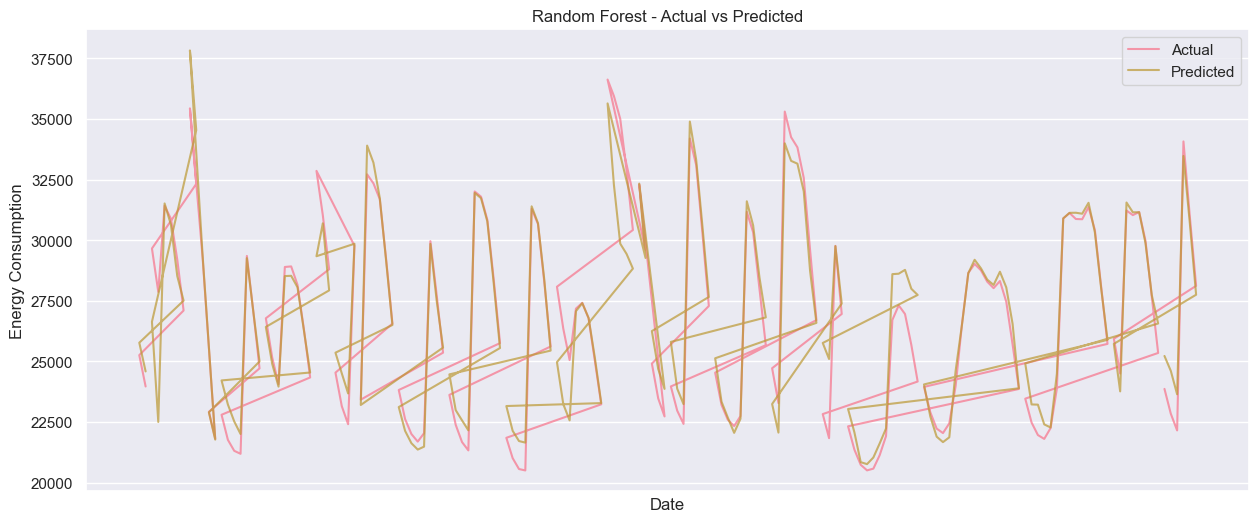


Top 10 Most Important Features:
                        feature  importance
21                         hour    0.391991
85                 is_peak_hour    0.120648
36                 PJME_lag_24h    0.106286
12   avg_temperature_washington    0.100087
4               min_temperature    0.091891
87  consumption_change_rate_24h    0.069152
67                temp_hour_sin    0.017083
35                   is_weekend    0.015440
24                  day_of_week    0.014465
27              day_of_week_sin    0.012797


<Figure size 1200x600 with 0 Axes>

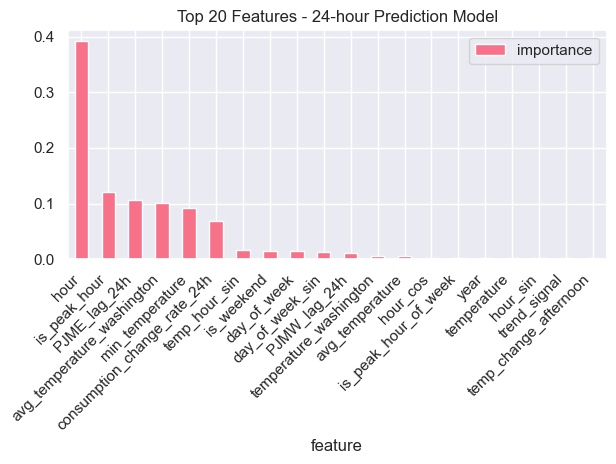

In [3]:
# Random Forest Model Implementation
def train_random_forest(X_train, X_test, y_train, y_test, n_estimators=100):
    """
    Train and evaluate a Random Forest model
    """
    print("Training Random Forest model...")
    
    # Initialize the model
    rf_model = RandomForestRegressor(
        n_estimators=n_estimators,
        random_state=42,
        n_jobs=-1  # Use all available cores
    )
    
    # Train the model
    rf_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rf_model.predict(X_test)
    
    # Evaluate the model
    metrics = evaluate_model(y_test, y_pred, "Random Forest")
    
    # Plot predictions
    plot_predictions(y_test, y_pred, "Random Forest - Actual vs Predicted")
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))
    
    return rf_model, metrics, feature_importance

# Train and evaluate 24-hour prediction model first
print("Training 24-hour prediction model:")
rf_model_24h, rf_metrics_24h, rf_importance_24h = train_random_forest(
    X_train_24h, X_test_24h, y_train_24h, y_test_24h
)

# Plot feature importance for 24h model
plt.figure(figsize=(12, 6))
rf_importance_24h.head(20).plot(
    kind='bar', 
    x='feature', 
    y='importance',
    title="Top 20 Features - 24-hour Prediction Model"
)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Preparing 7-day prediction data:
Removing 34 features that wouldn't be available for 168h forecasting:
['PJME_lag_1h', 'PJMW_lag_1h', 'PJME_lag_2h', 'PJME_lag_3h', 'PJME_lag_6h', 'PJMW_lag_6h', 'PJME_lag_12h', 'PJMW_lag_12h', 'PJME_lag_24h', 'PJMW_lag_24h', 'PJME_lag_48h', 'PJMW_lag_48h', 'PJME_lag_72h', 'PJMW_lag_72h', 'PJME_lag_96h', 'PJMW_lag_96h', 'PJME_lag_120h', 'PJMW_lag_120h', 'PJME_lag_144h', 'PJMW_lag_144h', 'PJME_rolling_std_6h', 'PJMW_rolling_std_6h', 'PJME_rolling_mean_12h', 'PJMW_rolling_mean_12h', 'PJME_rolling_std_12h', 'PJMW_rolling_std_12h', 'PJME_rolling_mean_24h', 'PJME_rolling_std_24h', 'PJMW_rolling_std_24h', 'PJME_rolling_mean_168h', 'PJMW_rolling_mean_168h', 'PJME_rolling_std_168h', 'PJMW_rolling_std_168h', 'consumption_change_rate']

Training set shape: (28664, 79)
Test set shape: (7167, 79)
Training period: 1970-01-01 00:00:00.000005081 to 1970-01-01 00:00:00.000026136
Test period: 1970-01-01 00:00:00.000026137 to 1970-01-01 00:00:00.000033188

Training 7-day

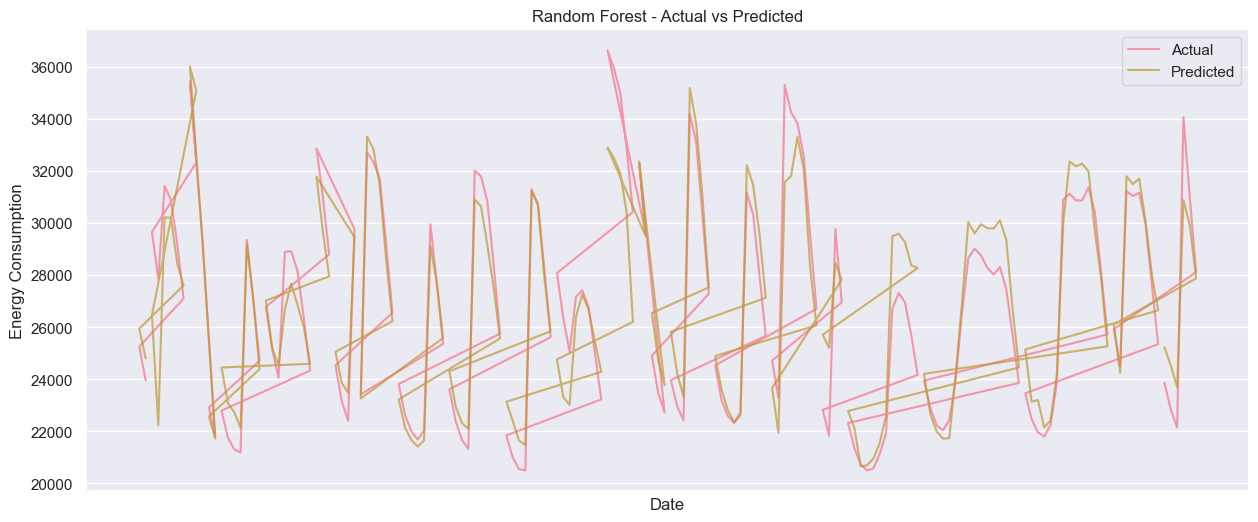


Top 10 Most Important Features:
                       feature  importance
21                        hour    0.399054
75                is_peak_hour    0.135338
12  avg_temperature_washington    0.129317
4              min_temperature    0.095277
2              avg_temperature    0.019981
35                  is_weekend    0.019370
24                 day_of_week    0.018777
27             day_of_week_sin    0.016593
57               temp_hour_sin    0.016038
76        is_peak_hour_of_week    0.009920


<Figure size 1200x600 with 0 Axes>

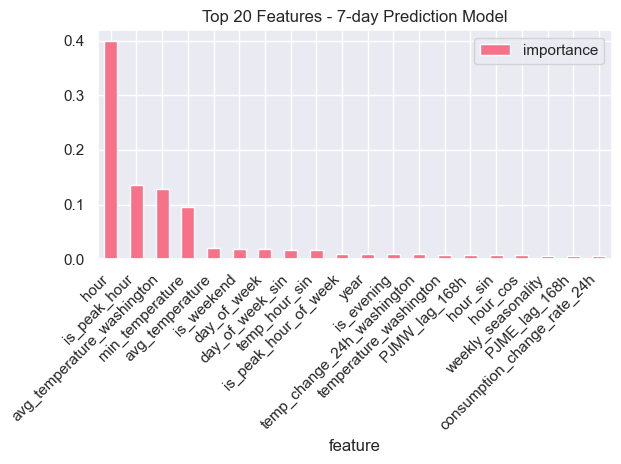


Performance Comparison:
24-hour predictions:
MAE: 367.35
RMSE: 675.55
R2: 0.98
MAPE: 1.27

7-day predictions:
MAE: 1108.54
RMSE: 1489.12
R2: 0.90
MAPE: 3.69


In [4]:
# Prepare data for 7d predictions
print("\nPreparing 7-day prediction data:")
X_train_7d, X_test_7d, y_train_7d, y_test_7d = prepare_data_for_modeling(
    df_7d, 
    forecast_horizon=168  # 7 days * 24 hours
)

# Train and evaluate 7-day prediction model
print("\nTraining 7-day prediction model:")
rf_model_7d, rf_metrics_7d, rf_importance_7d = train_random_forest(
    X_train_7d, X_test_7d, y_train_7d, y_test_7d
)

# Plot feature importance for 7d model
plt.figure(figsize=(12, 6))
rf_importance_7d.head(20).plot(
    kind='bar', 
    x='feature', 
    y='importance',
    title="Top 20 Features - 7-day Prediction Model"
)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Compare metrics between 24h and 7d predictions
print("\nPerformance Comparison:")
print("24-hour predictions:")
for metric, value in rf_metrics_24h.items():
    print(f"{metric.upper()}: {value:.2f}")

print("\n7-day predictions:")
for metric, value in rf_metrics_7d.items():
    print(f"{metric.upper()}: {value:.2f}")

Training 24-hour prediction model:
Training XGBoost model...

XGBoost Performance Metrics:
MAE: 292.01
RMSE: 431.50
R2 Score: 0.9918
MAPE: 0.99%


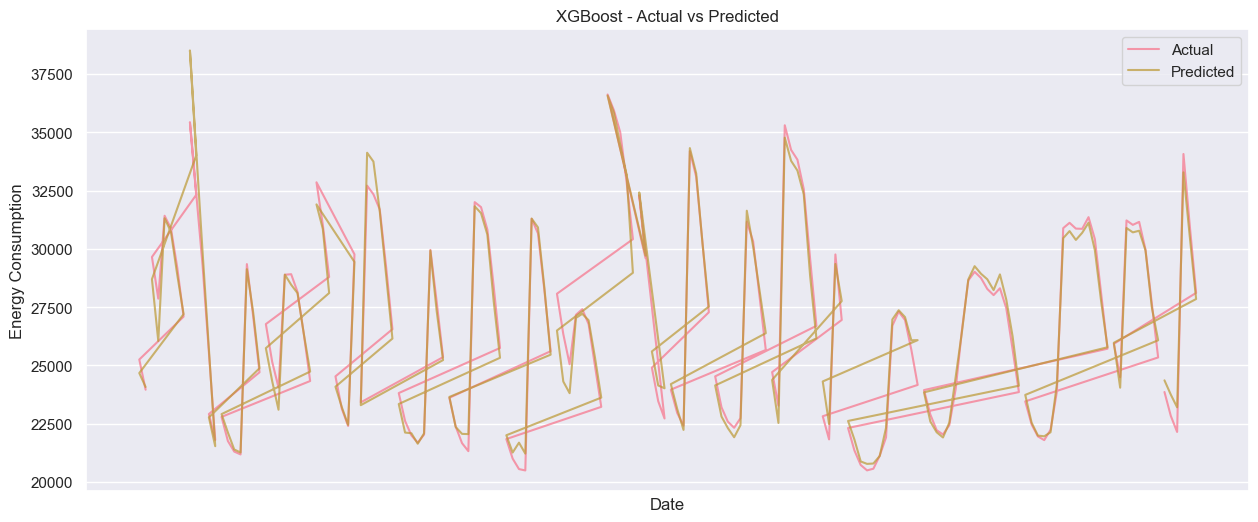


Top 10 Most Important Features:
                        feature  importance
21                         hour    0.267867
85                 is_peak_hour    0.189699
12   avg_temperature_washington    0.119607
4               min_temperature    0.090812
24                  day_of_week    0.056571
37                 PJMW_lag_24h    0.056316
86         is_peak_hour_of_week    0.036549
36                 PJME_lag_24h    0.033853
87  consumption_change_rate_24h    0.024522
67                temp_hour_sin    0.014849


<Figure size 1200x600 with 0 Axes>

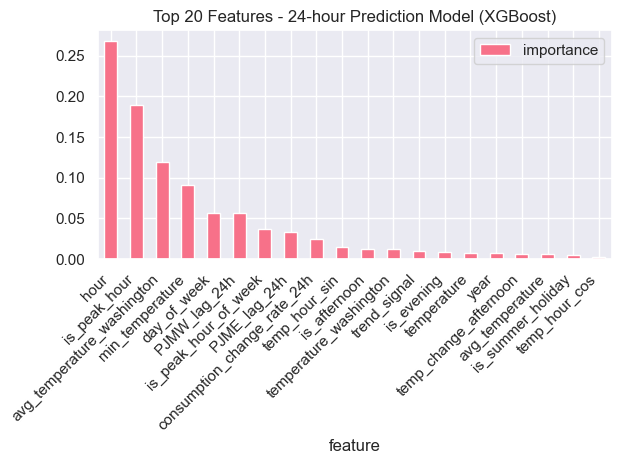


Training 7-day prediction model:
Training XGBoost model...

XGBoost Performance Metrics:
MAE: 936.27
RMSE: 1264.70
R2 Score: 0.9293
MAPE: 3.09%


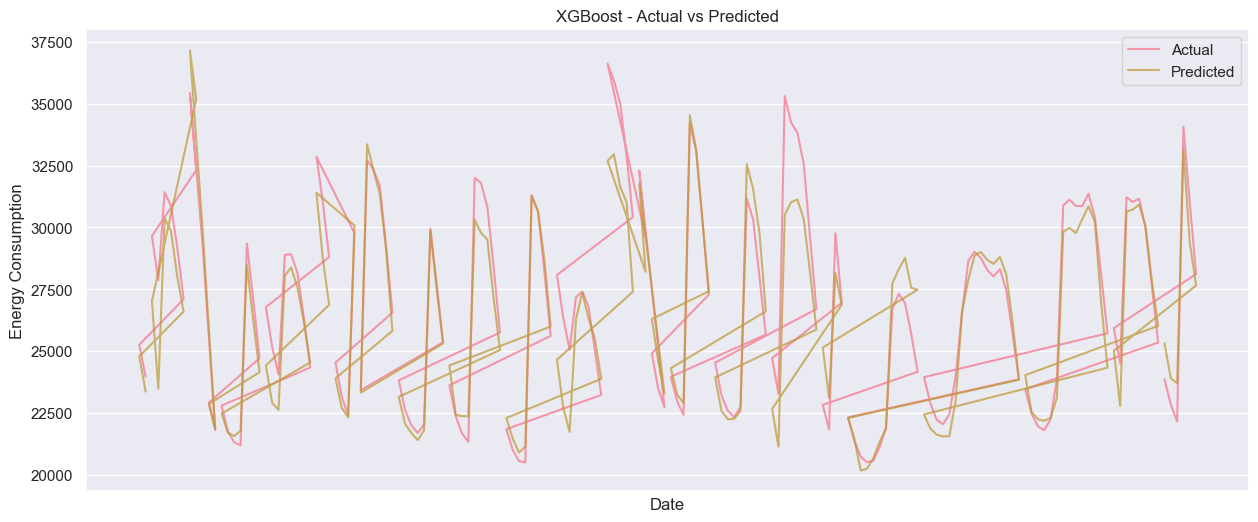


Top 10 Most Important Features:
                       feature  importance
75                is_peak_hour    0.217419
21                        hour    0.194302
12  avg_temperature_washington    0.115954
4              min_temperature    0.072017
24                 day_of_week    0.046885
76        is_peak_hour_of_week    0.039464
66                  temp_night    0.031938
33                  is_evening    0.029622
34                    is_night    0.024753
57               temp_hour_sin    0.022331


<Figure size 1200x600 with 0 Axes>

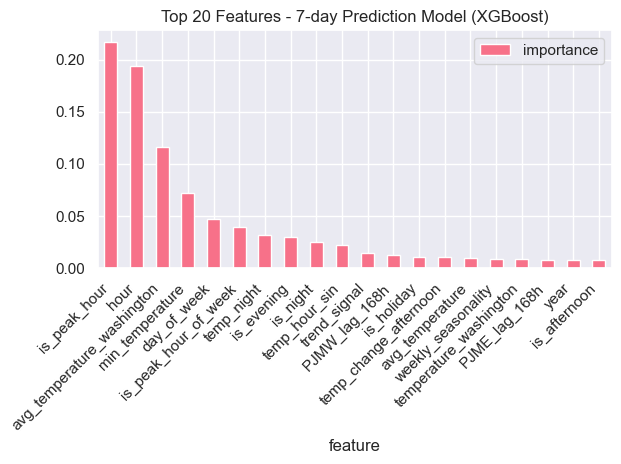


Performance Comparison:

Random Forest 24h:
MAE: 367.35
RMSE: 675.55
R2: 0.98
MAPE: 1.27

XGBoost 24h:
MAE: 292.01
RMSE: 431.50
R2: 0.99
MAPE: 0.99

Random Forest 7d:
MAE: 1108.54
RMSE: 1489.12
R2: 0.90
MAPE: 3.69

XGBoost 7d:
MAE: 936.27
RMSE: 1264.70
R2: 0.93
MAPE: 3.09


In [5]:
def train_xgboost(X_train, X_test, y_train, y_test, n_estimators=100):
    """
    Train and evaluate an XGBoost model
    """
    print("Training XGBoost model...")
    
    # Initialize the model
    xgb_model = xgb.XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=0.1,
        max_depth=7,
        random_state=42,
        n_jobs=-1
    )
    
    # Train the model
    xgb_model.fit(
        X_train, 
        y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )
    
    # Make predictions
    y_pred = xgb_model.predict(X_test)
    
    # Evaluate the model
    metrics = evaluate_model(y_test, y_pred, "XGBoost")
    
    # Plot predictions
    plot_predictions(y_test, y_pred, "XGBoost - Actual vs Predicted")
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))
    
    return xgb_model, metrics, feature_importance

# Train and evaluate 24-hour prediction model
print("Training 24-hour prediction model:")
xgb_model_24h, xgb_metrics_24h, xgb_importance_24h = train_xgboost(
    X_train_24h, X_test_24h, y_train_24h, y_test_24h
)

# Plot feature importance for 24h model
plt.figure(figsize=(12, 6))
xgb_importance_24h.head(20).plot(
    kind='bar', 
    x='feature', 
    y='importance',
    title="Top 20 Features - 24-hour Prediction Model (XGBoost)"
)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Train and evaluate 7-day prediction model
print("\nTraining 7-day prediction model:")
xgb_model_7d, xgb_metrics_7d, xgb_importance_7d = train_xgboost(
    X_train_7d, X_test_7d, y_train_7d, y_test_7d
)

# Plot feature importance for 7d model
plt.figure(figsize=(12, 6))
xgb_importance_7d.head(20).plot(
    kind='bar', 
    x='feature', 
    y='importance',
    title="Top 20 Features - 7-day Prediction Model (XGBoost)"
)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Compare all metrics
print("\nPerformance Comparison:")
print("\nRandom Forest 24h:")
for metric, value in rf_metrics_24h.items():
    print(f"{metric.upper()}: {value:.2f}")

print("\nXGBoost 24h:")
for metric, value in xgb_metrics_24h.items():
    print(f"{metric.upper()}: {value:.2f}")

print("\nRandom Forest 7d:")
for metric, value in rf_metrics_7d.items():
    print(f"{metric.upper()}: {value:.2f}")

print("\nXGBoost 7d:")
for metric, value in xgb_metrics_7d.items():
    print(f"{metric.upper()}: {value:.2f}")

In [7]:
from sklearn.preprocessing import MinMaxScaler

def prepare_data_for_lstm(df, target_col='PJME', sequence_length=24, forecast_horizon=24):
    """
    Prepare data for LSTM model by creating sequences
    """
    print("Preparing data for LSTM...")
    
    # Remove features we wouldn't have for future predictions
    future_lags = [col for col in df.columns if 'lag' in col and int(col.split('_')[-1].replace('h','')) < forecast_horizon]
    rolling_stats = [col for col in df.columns if 'rolling' in col]
    consumption_changes = ['consumption_change_rate']
    
    features_to_drop = future_lags + rolling_stats + consumption_changes
    df = df.drop(columns=features_to_drop)
    
    # Normalize the data - scale each column independently
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(data_scaled, columns=df.columns, index=df.index)
    
    # Verify no infinity or nan values
    print("Checking for invalid values after scaling:")
    print("NaN values:", np.isnan(data_scaled).sum())
    print("Inf values:", np.isinf(data_scaled).sum())
    
    # Create sequences
    X, y = [], []
    for i in range(len(df_scaled) - sequence_length - forecast_horizon + 1):
        X.append(df_scaled.iloc[i:(i + sequence_length)].drop(columns=[target_col]).values)
        y.append(df_scaled.iloc[i + sequence_length:i + sequence_length + forecast_horizon][target_col].values)
    
    X = np.array(X)
    y = np.array(y)
    
    # Split into train and test
    train_size = int(len(X) * 0.8)
    X_train = X[:train_size]
    X_test = X[train_size:]
    y_train = y[:train_size]
    y_test = y[train_size:]
    
    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test, scaler

def create_lstm_model(input_shape, output_length):
    """
    Create LSTM model architecture with more stable configuration
    """
    model = Sequential([
        LSTM(units=32, return_sequences=True, input_shape=input_shape,
             kernel_initializer='glorot_uniform',
             recurrent_initializer='orthogonal'),
        Dropout(0.1),
        LSTM(units=16, 
             kernel_initializer='glorot_uniform',
             recurrent_initializer='orthogonal'),
        Dropout(0.1),
        Dense(output_length)
    ])
    
    # Use a smaller learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae']
    )
    
    return model

def train_lstm(X_train, X_test, y_train, y_test, scaler, forecast_horizon, epochs=50):
    """
    Train and evaluate LSTM model with additional safeguards
    """
    print("Training LSTM model...")
    
    # Create and train model
    model = create_lstm_model(
        input_shape=(X_train.shape[1], X_train.shape[2]),
        output_length=forecast_horizon
    )
    
    # Add early stopping with more patience
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        mode='min'
    )
    
    # Add learning rate reduction on plateau
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.0001
    )
    
    # Clip gradients to prevent explosion
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.001,
        clipnorm=1.0
    )
    
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae']
    )
    
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=64,  # Increased batch size for stability
        validation_split=0.2,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Inverse transform predictions and actual values
    # Create dummy array to match the shape of the original data
    dummy = np.zeros((y_test.shape[0], scaler.n_features_in_))
    dummy[:, -1] = y_test.reshape(-1)  # Assuming target is the last column
    y_test_inv = scaler.inverse_transform(dummy)[:, -1]
    
    dummy[:, -1] = y_pred.reshape(-1)
    y_pred_inv = scaler.inverse_transform(dummy)[:, -1]
    
    # Evaluate
    metrics = evaluate_model(y_test_inv, y_pred_inv, "LSTM")
    
    # Plot predictions
    dates = df_24h.index[-(len(y_test_inv)):]
    plot_predictions(
        pd.Series(y_test_inv, index=dates),
        pd.Series(y_pred_inv, index=dates),
        "LSTM - Actual vs Predicted"
    )
    
    return model, metrics, history

# Prepare and train LSTM for 24h predictions
print("\nPreparing 24-hour LSTM model:")
X_train_lstm_24h, X_test_lstm_24h, y_train_lstm_24h, y_test_lstm_24h, scaler_24h = prepare_data_for_lstm(
    df_24h,
    forecast_horizon=24
)

lstm_model_24h, lstm_metrics_24h, history_24h = train_lstm(
    X_train_lstm_24h, X_test_lstm_24h,
    y_train_lstm_24h, y_test_lstm_24h,
    scaler_24h,
    forecast_horizon=24
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.plot(history_24h.history['loss'], label='Training Loss')
plt.plot(history_24h.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss - 24h Predictions')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Compare all models
print("\nFinal Performance Comparison:")
print("\nRandom Forest 24h:")
for metric, value in rf_metrics_24h.items():
    print(f"{metric.upper()}: {value:.2f}")

print("\nXGBoost 24h:")
for metric, value in xgb_metrics_24h.items():
    print(f"{metric.upper()}: {value:.2f}")

print("\nLSTM 24h:")
for metric, value in lstm_metrics_24h.items():
    print(f"{metric.upper()}: {value:.2f}")


Preparing 24-hour LSTM model:
Preparing data for LSTM...
Training set shape: (28742, 24, 89)
Test set shape: (7186, 24, 89)
Training LSTM model...
Epoch 1/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/50
109/719 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: nan - mae: nan

KeyboardInterrupt: 